In [1]:
import matplotlib.pyplot as plt
import numpy as cp
from tqdm import tqdm

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
num_classes = 10

#
# make a matrix each column of which represents an images in a vector form 
#
images  = cp.empty((num_image, size_row * size_col), dtype=float)
labels  = cp.empty(num_image, dtype=int)

for cnt, line in enumerate(data):

    line_data   = line.split(',')
    label       = int(line_data[0])
    im_vector   = cp.array(list(map(int, line_data[1:])))

    labels[cnt]    = label
    images[cnt]    = im_vector

# one-hot
labels = cp.eye(num_classes)[labels]
images = images / 255
    
# Split Data
train_images = images[:6000]
train_labels = labels[:6000]
test_images = images[6000:]
test_labels = labels[:6000]

In [2]:
# Define module

class Linear:
    def __init__(self, in_shapes, out_shapes):
        self.weight = cp.random.normal(0, 0.001, (in_shapes, out_shapes))
        self.input = 0
    
    def __call__(self, x):
        self.input = x
        return x @ self.weight
    
    def backprop(self):
        return self.weight
        

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))
    
class Sigmoid:
    output = 0
    
    def __call__(self, x):
        self.output = 1 / (1 + cp.exp(-x))
        return 1 / (1 + cp.exp(-x))
    
    def backprop(self):
        return self.output * (1 - self.output)
        
    
class Sequential:
    def __init__(self, modules: list):
        self.module_list = modules
        self.error_list = []
    
    def __call__(self, x):
        for layer in self.module_list:
            x = layer(x)
            
        return x
    
    def backprop(self, preds, labels, criterion):
        s_val = criterion.backprop()

        for layer in reversed(self.module_list):
            if isinstance(layer, Sigmoid):
                s_val *= layer.backprop()
            else:
                self.error_list += [(layer.input.T @ s_val)]
                s_val = s_val @ layer.backprop().T
                
                del layer.input
        self.error_list.reverse()
        
    def step(self, lr):
        cnt = 0
        for layer in self.module_list:
            if isinstance(layer, Linear):
                layer.weight = layer.weight - lr * self.error_list[cnt]
                cnt += 1
            
        
class BinaryCrossEntropy:
    labels = 0
    preds = 0
    def __call__(self, preds, labels):
        self.labels = labels
        self.preds = preds
        
        return -(labels * cp.log(preds) + (1 - labels) * cp.log(1 - preds)).mean()
    
    def backprop(self):
        return -self.labels / self.preds + (1 - self.labels) / (1 - self.preds)
    
class LearningRateScheduler:
    def __init__(self, init_lr, final_step, warm_up_step = 0):
        self.init_lr = init_lr
        self.final_step = final_step
        self.warm_up_step = warm_up_step
        self.lr = 0
        self._step = 0
    
    def step(self):
        self._step += 1
        if (step < self.warm_up_step):
            self.lr = (self.init_lr / self.warm_up_step) * self._step
        else:
            self.lr = (cp.cos(cp.pi * ((self._step - self.warm_up_step) / (self.final_step - self.warm_up_step))) + 1) / 2 * self.init_lr
        
    def get_lr(self):
        return self.lr

In [3]:
def compute_acc(preds, labels):
    pred_nums = cp.argmax(preds, axis=1)
    lable_nums = cp.argmax(labels, axis=1)
    num_correct = (pred_nums == lable_nums).sum()
    return (pred_nums == lable_nums).sum() / preds.shape[0]

In [4]:
epoch = 10000
warm_up_epoch = epoch // 10
initial_lr = 1

model = Sequential([
    Linear(784, 196),
    Sigmoid(),
    Linear(196, 49),
    Sigmoid(),
    Linear(49, 10),
    Sigmoid()
])

criterion = BinaryCrossEntropy()
lr = LearningRateScheduler(initial_lr, epoch, warm_up_epoch)

In [5]:
preds = model(train_images)
loss = criterion(preds, train_labels)
model.backprop(preds, labels, criterion)

In [6]:
accuracyes = []
losses = []
lrs = []

for step in tqdm(range(epoch)):
    preds = model(train_images)
    loss = criterion(preds, train_labels)
    acc = compute_acc(preds, train_labels)
    
    model.backprop(preds, labels, criterion)
    model.step(0.1)
    
    accuracyes += [acc]
    losses += [loss]
    lrs += [lr.lr]
    
    lr.step()

  0%|                                                                                | 1/10000 [00:00<20:36,  8.09it/s]c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
c:\users\jtige\appdata\local\continuum\anaconda3\envs\cupy37\lib\site-packages\ipykernel_launcher.py:72: R

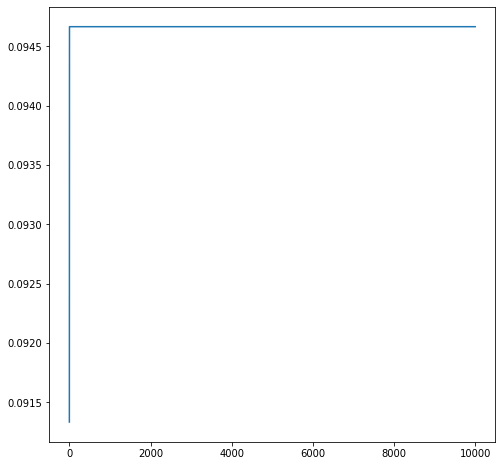

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(accuracyes)
plt.show()

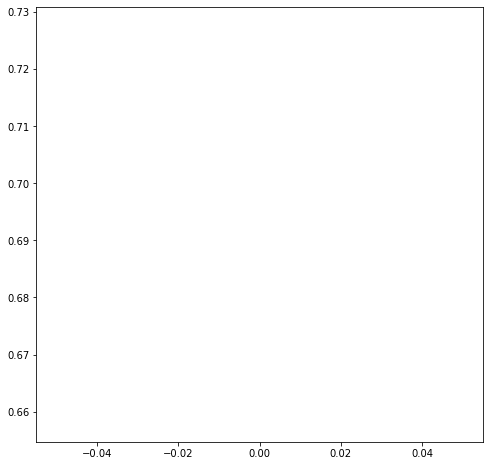

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show()

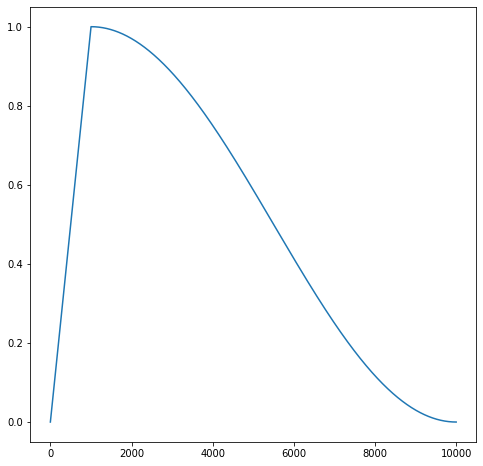

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(lrs)
plt.show()